# Imports

In [1]:
import sys

sys.path.append("./src")
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from src.ngs_analysis import ngs_expr_set
from src.utils import defaultStyle, save_fig
from src.data_storage import random_mutant_dataset, virus_seqs
import pandas as pd
from itertools import product
import torch
import os
from src.model_config import ModelConfig, model_collections
from src.data_storage import random_mutant_dataset, virus_seqs
import data
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
defaultStyle()

# Linear regression model

## model predict input

In [41]:
virus_name, date = 'VEE', '0412'
original_seq = virus_seqs(virus_name).original_seq

def substitution(seq, i, target):
    seq_arr = list(seq)
    seq_arr[i] = target
    return "".join(seq_arr)

def two_substitution(seq, i,j, target):
    seq_arr = list(seq)
    seq_arr[i] = target[0]
    seq_arr[j] = target[1]
    return "".join(seq_arr)

seq_df = pd.DataFrame(
                        columns=["seq","score"],
                        dtype=float,
                    )

seq_tol = []

for idx in range(0,43):
    for jdx in range(idx+1,44):
        symbol = set("ATGC")
        muti_list = list(symbol - {original_seq[idx]})
        subsi = [substitution(original_seq, idx, target) for target in muti_list]

        mutj_list = list(symbol - {original_seq[jdx]})
        subsj = [substitution(original_seq, jdx, target) for target in mutj_list]

        ori_two = original_seq[idx] + original_seq[jdx]
        symbol = set([''.join(s) for s in list(product(*['ATCG'] * 2))])
        mutij_list = list(symbol - {original_seq[idx] + original_seq[jdx]})
        
        subij = [two_substitution(original_seq, idx, jdx, target) for target in mutij_list]
        list_mid = subsi + subsj + subij
        mut = muti_list + mutj_list + mutij_list
        seq_tol.append(list_mid)
seq_tol = [x for item in seq_tol for x in item]      
seq_df['seq'] = pd.DataFrame(seq_tol)
seq_df = seq_df.drop_duplicates(subset=['seq'])
seq_df.reset_index(inplace=True,
                drop=True)

model_name = "deepcnnlstm"
mconf = ModelConfig(model_name)
model = model_collections[model_name](mconf)

model.load_state_dict(torch.load(f'../models/VEE.0817.deepcnnlstm.params.train.14004'))
model.eval()
test_path = f"./data/VEE_0816_epistasis.csv"
data_size = len(pd.read_csv(test_path))
if model_name == "bert":
    test_data = data.BERTDataset(test_path)
else:
    test_data = data.NormalDataset(test_path)
loader = DataLoader(test_data, batch_size=data_size)

# Forward the test set
with torch.no_grad():
    for batch in loader:
        out, loss = model(*batch)
out = out.cpu().numpy()
seq_df['score'] = pd.DataFrame(out)
seq_df.to_csv("./data/VEE_0816_epistasis.csv",
            index=False)
seq_df

,seq,score
0,TTGGGCGGCGCATGAGAGAAGCCCAGACCAATTACCTACCCAAA,-1.696580
1,GTGGGCGGCGCATGAGAGAAGCCCAGACCAATTACCTACCCAAA,-1.325530
2,CTGGGCGGCGCATGAGAGAAGCCCAGACCAATTACCTACCCAAA,-2.654583
3,ACGGGCGGCGCATGAGAGAAGCCCAGACCAATTACCTACCCAAA,-2.241791
4,AAGGGCGGCGCATGAGAGAAGCCCAGACCAATTACCTACCCAAA,1.469612
...,...,...
8641,ATGGGCGGCGCATGAGAGAAGCCCAGACCAATTACCTACCCACT,0.655128
8642,ATGGGCGGCGCATGAGAGAAGCCCAGACCAATTACCTACCCATT,0.584305
8643,ATGGGCGGCGCATGAGAGAAGCCCAGACCAATTACCTACCCAGG,0.285204
8644,ATGGGCGGCGCATGAGAGAAGCCCAGACCAATTACCTACCCATC,0.687903


## Feature extraction

In [5]:
def one_hot_encode(s):
    one_hot_arr = np.eye(4)
    return np.concatenate([one_hot_arr[i, :].reshape((-1, 1)) for i in s], axis=1)


# import frequency data
# virus_name, date = "VEE", "0412"
# ngs = ngs_expr_set(virus_name=virus_name, date=date)
# freq_df = ngs.merged_freq_df
# freq_df = freq_df.sample(n=10000)
# freq_df.reset_index(inplace=True)
# print(freq_df)

# freq_df = pd.read_csv('./data/VEE_0816_epistasis.csv')
freq_df = pd.read_csv('./data/VEE_0611.csv')
# One-hot encoding
freq_df["input_arr"] = freq_df.seq.apply(lambda s: ["ATCG".find(nt) for nt in s])
freq_df["input_arr"] = freq_df.input_arr.apply(one_hot_encode)

# Second-order features
poly = PolynomialFeatures(degree=2, interaction_only=True)
freq_df.input_arr = freq_df.input_arr.apply(
    lambda arr: arr.flatten(order="F").reshape((1, -1))
)

print(freq_df.input_arr)
freq_df.input_arr = freq_df.input_arr.apply(poly.fit_transform)
print(freq_df.input_arr)
start = 44
mask = np.ones(15577)
flag = 0
total = 0
for i in np.arange(175, 0, -1):
    if flag == 0:
        flag = 3
    else:
        flag -= 1
    mask[start : start + flag] = 0
    # print(start, start+flag)
    total += flag
    start += i
freq_df.input_arr = freq_df.input_arr.apply(lambda x: x[:, mask == 1])

print("Shape of input:", freq_df.loc[0, "input_arr"].shape)

# X = np.concatenate(freq_df.input_arr.tolist(), axis=0)
# y = freq_df.score.values
# np.save("temp/epistasis_linear_features_first_order.npy", {"X": X, "y": y})

0        [[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
1        [[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
2        [[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
3        [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...
4        [[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0,...
                               ...                        
18173    [[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
18174    [[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
18175    [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...
18176    [[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
18177    [[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...
Name: input_arr, Length: 18178, dtype: object
0        [[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...
1        [[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...
2        [[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...
3        [[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...
4        [[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0,...
          

## Training

In [2]:
# Train the LR model
# %reset -f
data_np = np.load("temp/epistasis_linear_features_first_order.npy", allow_pickle=True).item()
X, y = data_np["X"], data_np["y"]

alpha = 0.001
reg = Lasso(alpha=alpha, fit_intercept=False).fit(
    X[: X.shape[0] // 10 * 9, :], y[: len(y) // 10 * 9]
)

/home/dell/anaconda3/envs/utr/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.100e+03, tolerance: 5.555e+00
  model = cd_fast.enet_coordinate_descent(


## Evaluation

In [3]:
y_pred = reg.predict(X[-X.shape[0] // 10 :, :])
print("Pearson r:", pearsonr(y_pred.flatten(), y[-len(y) // 10 :])[0])

Pearson r: 0.8582575464446627


## Epistasis map

In [5]:
independent_coef = abs(reg.coef_[1 : 4 * 44 + 1].reshape((4, -1), order="F")).sum(axis=0)
independent_coef = (independent_coef - independent_coef.min()) / (
   independent_coef.max() - independent_coef.min()
)

In [6]:
independent_coef

array([0.12489035, 1.        , 0.82244744, 0.17628253, 0.        ,
       0.42965006, 0.        , 0.        , 0.16956471, 0.        ,
       0.        , 0.20255927, 0.        , 0.61083309, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00955586, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02072366, 0.        , 0.        , 0.23483501,
       0.37651768, 0.        , 0.17955448, 0.0214696 , 0.01644304,
       0.        , 0.        , 0.        , 0.        ])

[0.7078508  0.53440232 0.51716343 ... 0.         0.         0.        ]
0 43
0
172
[[6.34473268e-01 6.06398182e-01 3.05007211e-02 3.50376067e-01
  3.76705102e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 5.92238031e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.28067030e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.57267709e-02 0.00000000e+00 7.19404947e-03 0.00000000e+00
  8.25789415e-02 0.00000000e+00 3.37676840e-02 1.81109447e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 6.07225717e-02 1.00637972e-01 0.00000000e+00
  0.00000000e+00 1.09632925e-01 5.58892503e-02 9.87867019e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.79004884e-01 6.23689090e-01 5.81608197e-01 3.06371369e-01
  0.00000000e+00 1.77936203e-01 2.28429248e-02 0.00000000e+00
  3.66318041e-02 0.00000000e+00 5.71479313e-02 0.00000000e+00
  1.17808904e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 

/tmp/ipykernel_4952/3904556722.py:56: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(interaction_mat,dtype=np.bool)


[Text(0, 0.5, '1'),
 Text(1, 0.5, '1'),
 Text(0, 4.5, '5'),
 Text(1, 4.5, '5'),
 Text(0, 8.5, '9'),
 Text(1, 8.5, '9'),
 Text(0, 12.5, '13'),
 Text(1, 12.5, '13'),
 Text(0, 16.5, '17'),
 Text(1, 16.5, '17'),
 Text(0, 20.5, '21'),
 Text(1, 20.5, '21'),
 Text(0, 24.5, '25'),
 Text(1, 24.5, '25'),
 Text(0, 28.5, '29'),
 Text(1, 28.5, '29'),
 Text(0, 32.5, '33'),
 Text(1, 32.5, '33'),
 Text(0, 36.5, '37'),
 Text(1, 36.5, '37'),
 Text(0, 40.5, '41'),
 Text(1, 40.5, '41')]

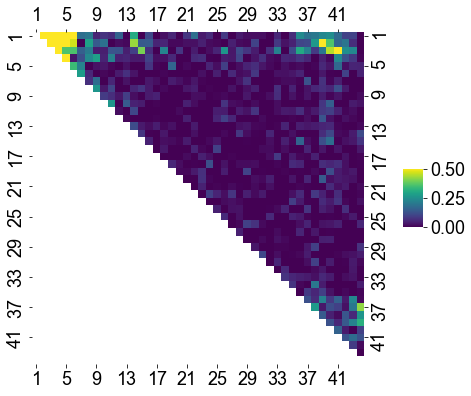

In [11]:
interaction_coef = abs(reg.coef_[4 * 44 + 1:])
print(interaction_coef)
interaction_coef = (interaction_coef - interaction_coef.min()) / (
    interaction_coef.max() - interaction_coef.min()
)
interaction_mat = np.zeros((44, 44)) + np.diag(independent_coef)
start_idx = 0
for i, n in enumerate(range(43, 0, -1)):
    coef = []
    for _ in range(4):
        print(i,n)
        print(start_idx)
        print(start_idx + n * 4)
        print(interaction_coef[start_idx:start_idx + n * 4].reshape((4, -1), order="F"))
        print(interaction_coef[start_idx:start_idx + n * 4].reshape((4, -1), order="F").sum(axis=0))
        coef.append(interaction_coef[start_idx:start_idx + n * 4].reshape((4, -1), order="F").sum(axis=0).tolist())
        start_idx += 4 * n
    interaction_mat[i, i + 1 :] = np.array(coef).sum(axis=0)

def cre_color(r,g,b):
    return [r/256,g/256,b/256]

colors = [

    # cre_color(248,248,248),
    # cre_color(165,140,200),
    # cre_color(160,135,190),
    # cre_color(155,130,185),
    # cre_color(145,120,180),
    # cre_color(120,105,165),
    # cre_color(115,100,150),
    # cre_color(105,95,145),
    # cre_color(100,90,140),
    # cre_color(95,85,135),
    # cre_color(90,80,130),
    # cre_color(85,75,125),

    cre_color(248,248,248),
    cre_color(200,140,165),
    cre_color(190,135,160),
    cre_color(185,130,155),
    cre_color(180,120,145),
    cre_color(165,105,120),
    cre_color(150,100,115),
    cre_color(145,95,105),
    cre_color(140,90,100),
    cre_color(135,85,95),
    cre_color(130,80,90),
    cre_color(125,75,85),
]

cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)


_, ax = plt.subplots(1, 1, figsize=(7,7))
mask = np.zeros_like(interaction_mat,dtype=np.bool)
mask[np.tril_indices_from(mask)] = True
interaction_mat_scale = []
for item in interaction_mat:
    item = np.log10(item+1)
    interaction_mat_scale.append(item)
sns.heatmap(abs(interaction_mat), 
            vmax=0.5,
            mask=mask,
            cmap='viridis', 
            # center=0.28,
            square=True,
            ax=ax,
            cbar_kws={'ticks':[0,0.25,0.5],'pad':0.1,'fraction':0.05,'aspect':3,'shrink':3,'location':'right'},
            )
ax.tick_params(top='on',bottom='off',right='on',left='off')
ax.tick_params(labeltop='on',labelbottom='off',labelright='on',labelleft='off')
ax.set_xticks(np.array(range(0,44,4))+0.5)
ax.set_yticks(np.array(range(0,44,4))+0.5)
ax.set_xticklabels(np.array(range(0,44,4))+1)
ax.set_yticklabels(np.array(range(0,44,4))+1)

# save_fig('vee_epi_plos')

In [9]:
interaction_coef.max()

1.0

In [7]:
independent_coef = abs(reg.coef_[1 : 4 * 44 + 1].reshape((4, -1), order="F")).mean(axis=0)
interaction_mat_tol = interaction_mat + interaction_mat.T
print(interaction_mat_tol)
dependent_coef_ave = abs(interaction_mat_tol).mean(axis=0)
dependent_coef_ave

[[0.16428064 3.33333085 2.87951416 ... 0.09927514 0.09784503 0.        ]
 [3.33333085 1.31539895 2.83096475 ... 0.19499739 0.06419718 0.        ]
 [2.87951416 2.83096475 1.0818465  ... 0.24756239 0.23428911 0.        ]
 ...
 [0.09927514 0.19499739 0.24756239 ... 0.         0.08630518 0.01219201]
 [0.09784503 0.06419718 0.23428911 ... 0.08630518 0.         0.        ]
 [0.         0.         0.         ... 0.01219201 0.         0.        ]]


array([0.29176272, 0.31570216, 0.31372809, 0.17691283, 0.09446643,
       0.07605539, 0.04081165, 0.05059127, 0.04254946, 0.03375317,
       0.03830464, 0.02658631, 0.02473579, 0.06069397, 0.03722538,
       0.02321309, 0.01141073, 0.02300101, 0.02029738, 0.01420618,
       0.0122176 , 0.0262957 , 0.01802508, 0.01734413, 0.01613101,
       0.02870252, 0.01218778, 0.01660323, 0.0193441 , 0.02007195,
       0.01314772, 0.01130149, 0.02588129, 0.01901872, 0.03269511,
       0.06324078, 0.0579316 , 0.05801615, 0.08539957, 0.06658689,
       0.06415312, 0.0391205 , 0.04161872, 0.04242789])

Saving figure vee_epi_cof_plos


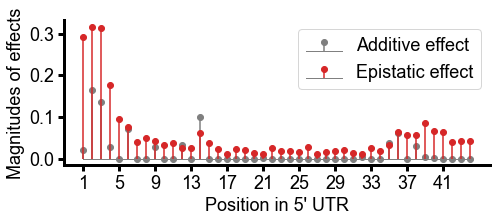

In [13]:
_, ax = plt.subplots(1, 1, figsize=(7,3))
# markerline, stemlines, baseline = plt.stem(np.log10(independent_coef+1e-3)+3,
#                                            bottom=0,
#                                            linefmt='C7-',
#                                            markerfmt='C7o',
#                                            )
# plt.setp(baseline,color='gray',linewidth=1)
# markerline, stemlines, baseline = plt.stem(np.log10(dependent_coef_ave+1e-3)+3,
#                                            bottom=0,
#                                            linefmt='C3-',
#                                            markerfmt='C3o',
#                                            )

markerline, stemlines, baseline = plt.stem(independent_coef,
                                           bottom=0,
                                           linefmt='C7-',
                                           markerfmt='C7o',
                                           )
plt.setp(baseline,color='gray',linewidth=1)
markerline, stemlines, baseline = plt.stem(dependent_coef_ave,
                                           bottom=0,
                                           linefmt='C3-',
                                           markerfmt='C3o',
                                           )
plt.setp(baseline,color='gray',linewidth=1)
ax.set_yticks([0,0.1,0.2,0.3])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Position in 5\' UTR')
ax.set_ylabel('Magnitudes of effects')
ax.set_xticks(np.array(range(0,44,4)))
ax.set_xticklabels(np.array(range(0,44,4))+1)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
ax.tick_params(width=3, length=6) 
ax.legend(['Additive effect','Epistatic effect'],fontsize=18)
save_fig('vee_epi_cof_plos')